In [2]:
!pip install qutip
from qutip import *
from tqdm import tqdm
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time
from mpl_toolkits.mplot3d import Axes3D
import math


In [3]:
import eigenfns
import arch

In [4]:
import importlib
importlib.reload(arch)

<module 'arch' from 'C:\\Users\\Administrator\\Sanket\\arch.py'>

In [5]:
from eigenfns import *
from arch import *

In [ ]:
def create_param(no,error_list = -1):
    N = 5
    Nlevel = 4
    Ej = np.array([190.46818206, 208.85824081, 217.42951792, 223.61288953, 213.73675511])
    Ec =  np.array([2.05876475, 3.62348055, 3.40815957, 2.50840228, 2.59757386])
    
    if error_list == -1:
        error_list = np.zeros(no)
        
    param_arr = []
    for i in range(no):
        param_arr.append([N, Nlevel,Ej,Ec,error_list[i]])
    
    return param_arr

def create_arch(param_arr):
    #format of param_arr: (N,Nlevel, Ej, Ec,error)
    t_arch_arr = []
    for p in param_arr:
        #print(p)
        t_arch = transmon_arch(int(p[0]),int(p[1]),p[4])
        t_arch.Ej = p[2]
        t_arch.Ec = p[3]
        t_arch.H_c()
        t_arch_arr.append(t_arch)
    
    return t_arch_arr

def run_arch(t_arch_arr,tlist, update = False, global_error_list = -1):
    
    run_arch_arr = []    
    if global_error_list == -1:
        global_error_list = np.zeros(len(t_arch_arr))
            
    for i in range(len(t_arch_arr)):
        run = run_data(t_arch_arr[i], tlist,update_error = update, global_error = global_error_list[i])
        run.spectrum_cal()
        run.cspectrum_cal()
        run_arch_arr.append(run)
    
    return run_arch_arr

def run_plot_spectrum(run_arch_arr):
    pl_arr = []
    plc_arr = []
    for run in run_arch_arr:
        pl = plot_spectrum(run.t_arch.N,run.t_arch.Nlevel,run.spectrum_arr)
        plc = plot_spectrum(run.t_arch.N,run.t_arch.Nlevel,run.cspectrum_arr)
        pl.title = str(pl.title+"\n Ec = " + str(run.t_arch.Ec)+" var = "+ str(np.var(run.t_arch.Ec))+"\n Ej = " + str(run.t_arch.Ej)+ " var = "+ str(np.var(run.t_arch.Ej)))
        pl.title = str(pl.title + "\n error width = "+str(run.t_arch.error) + "global error width = "+str(run.global_error))
        plc.title = pl.title
        pl_arr.append(pl)
        plc_arr.append(plc)
    
    return pl_arr,plc_arr

In [ ]:
tlist = np.linspace(0, 1, 1000)
param_arr = create_param(1,[0.0])

In [ ]:
archarr = create_arch(param_arr)
runarr = run_arch(archarr,tlist,[0.0])
plarr,plcarr = run_plot_spectrum(runarr)

In [ ]:
plarr[0].view_fig(y_min = 490, y_max = 500)
#y_min = 750, y_max = 800

In [ ]:
vec = runarr[0].c_evec[0][25]
overlap = []
overlapnorm = []
for v in runarr[0].c_evec[100]:
    overlap.append(np.real(vec.overlap(v)))
    

In [ ]:
overlap

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(range(len(overlap)),overlap)
#plt.scatter(range(len(overlap)),overlap,s = 0.5)
plt.title("overlap")
plt.xlabel("cstates")
plt.ylabel("inner product")

Code for Tracing

In [15]:
class trace_run:

    def slope_cal(self,arr):
        if (arr[2]-arr[0]) == 0:
            return 0
        else:
            return (arr[3]-arr[1])/(arr[2]-arr[0])

    def l1norm_y(self,y,y_arr):
        dist_y = []
        for y2 in y_arr:
            dist_y.append(abs(y-y2))
        return dist_y


    def trace_state(self,run):
        if run.spectrum_arr ==0:
            run.spectrum_cal
        t_arr = run.spectrum_arr
        
        traj_x = []
        traj_y = []
        traj_x.append(self.point[0])
        traj_y.append(self.point[1])
        traj_x.append(self.point[0])
        traj_y.append(self.point[1])
       
        for i in range(1,len(t_arr)):
            arr = [traj_x[i-1],traj_y[i-1],traj_x[i],traj_y[i]]
            slope_now = self.slope_cal(arr)
            #substract always to accomodate for variable T scales if required
            nexty = slope_now * (t_arr[i][0]-t_arr[i-1][0]) + traj_y[i]
            dist_y = self.l1norm_y(nexty,t_arr[i][1])
            dist_y_sort = np.sort(dist_y)
            index = dist_y.index(dist_y_sort[0])

            traj_x.append(t_arr[i][0])
            traj_y.append(t_arr[i][1][index])
        #remove extra initial points added
        traj_x = traj_x[1:]
        traj_y = traj_y[1:]
        t_arr_temp = []
        for x,y in zip(traj_x,traj_y):
            t_arr_temp.append([x,[y],self.label])
        self.trace_spectrum = t_arr_temp
        self.tlist = run.tlist

    def __init__(self,run,point,label=[[0]]):
        self.point = point
        self.tlist = 0
        self.trace_spectrum = 0
        self.label = label
        self.trace_state(run)
        

In [16]:
tarch = transmon_arch(5,4)
tlist = np.linspace(0,1,400)
run = run_data(tarch,tlist)
run.cal_all()

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [05:34<00:00,  1.20it/s]


In [ ]:
plt_c = plot_spectrum(tarch.N,tarch.Nlevel,run.cspectrum_arr)

In [ ]:
plt_c.c = 'r'
plt_c.size = 8
plt_c.view_fig()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.ylim(-10, 200)

plt.scatter(plt0.x,plt0.y,s = 0.5, color = plt0.c, alpha=0.5)
plt.scatter(plt_c.x,plt_c.y,s=0.5, color = plt_c.c, alpha=0.5)
plt.title(str("computational states overlapped on the spectrum"))
plt.xlabel("Coupling Strength")
plt.ylabel("Energy")

In [ ]:
plt0 = plot_spectrum(tarch.N,tarch.Nlevel,run.spectrum_arr)

In [ ]:
plt0.c = 'lightsteelblue'
plt0.size = 8
plt0.view_fig(y_min = 177, y_max = 180)

In [ ]:
run.cspectrum_arr[0][2][15]

In [ ]:
point = (0,run.cspectrum_arr[0][1][14])
label = run.cspectrum_arr[0][2][14]

In [ ]:
trace1 = trace_run(run,point,label)

In [ ]:
trace1.trace_spectrum[1]

In [ ]:
plt1 = plot_spectrum(tarch.N,tarch.Nlevel,trace1.trace_spectrum)

In [ ]:
plt1.c = "pink"
plt1.view_fig()

In [ ]:
mult_plot(plt1,plt_c,size = 8,y_min = 125, y_max = 150)

Walsh Transform

In [17]:
class cb_traj_run:
#class for each indivisual Cb string
    def group_bstring(self):
        #returns maximal diff between two 1s in bitstring
        #bstring is numpy array
        n = len(self.bstring)
        i = np.where(self.bstring == 1)
        if len(i) <= 1:
            return (-1)
        diff = max(i)-min(i)
        return diff

    def WH_transform(self,b1,b2_arr,Eb2_arr):
        #b1,b2 are numpy arrays and list of arrays that represent bitstring
        #Eb2 is energy associated with b2 state at some T value
        cb = 0
        #cb needs to be divided by 2^N
        for b2,Eb2 in zip(b2_arr,Eb2_arr):
            b_dot = np.sum(np.multiply(b1,b2))
            cb += ((-1)**b_dot)*Eb2
        
        #return abs(cb/2**N)
        N = len(Eb2_arr)
        return (abs(cb)/2**N)


    def prep_data(self,trace_class_arr):
        #coverts each spectrum into t_arr type data
        tlist = trace_class_arr[0].tlist
        t_arr_e = []
        t_arr_b = []
        for i in range(len(tlist)):
            arr_e = []
            arr_b = []
            for trace in trace_class_arr:
                arr_e.append(trace.trace_spectrum[i][1][0])
                arr_b.append(trace.trace_spectrum[i][2])
            
            t_arr_e.append(arr_e)
            t_arr_b.append(arr_b)
        
        return tlist, t_arr_e,t_arr_b
              
    def cb_cal_traj(self,trace_class_arr):
        #calculate cb value at each T
        #trace_class_arr is array of tracc_classes for each traced initial cstate
        cb_traj = []
        tlist, t_arr_e,t_arr_b = self.prep_data(trace_class_arr)
        for i in range(len(tlist)):
            cb_t = self.WH_transform(self.bstring,t_arr_b[i],t_arr_e[i])
            cb_traj.append([tlist[i],[cb_t],self.bstring])

        self.cb_spectrum = cb_traj
        self.tlist = tlist

    def __init__(self,bstring,trace_class_arr):
        self.bstring = bstring
        self.group = self.group_bstring()
        self.cb_spectrum = 0
        self.tlist = 0
        self.cb_cal_traj(trace_class_arr)


In [70]:
#generate all possible cb strings i.e bitstrings that have atleast two 1's
N = 5
bstrings_all = []
for i in range(N):
    for j in range(N-i-1):
        bstring = [0]*N
        bstring[j] = 1
        bstring[j+i+1] = 1
        #for k in range(j+1,j+i+1):
         #   bstring[k] = np.random.randint(0, 1)
        bstrings_all.append([i,bstring])

In [71]:
bstrings_all

[[0, [1, 1, 0, 0, 0]],
 [0, [0, 1, 1, 0, 0]],
 [0, [0, 0, 1, 1, 0]],
 [0, [0, 0, 0, 1, 1]],
 [1, [1, 0, 1, 0, 0]],
 [1, [0, 1, 0, 1, 0]],
 [1, [0, 0, 1, 0, 1]],
 [2, [1, 0, 0, 1, 0]],
 [2, [0, 1, 0, 0, 1]],
 [3, [1, 0, 0, 0, 1]]]

In [149]:
bstrings_all = [[1, [0, 1, 1, 1, 0]],
 [2, [0, 1, 1, 1, 1]]]

In [72]:
run1 = run

In [150]:
#run tracing for each of cstates
trace_class_arr = []
for e,l in zip(run1.cspectrum_arr[0][1],run1.cspectrum_arr[0][2]):
    trace_temp = trace_run(run1, point=[0,e], label =l)
    trace_class_arr.append(trace_temp)

In [151]:
cb_arr = []
for b in bstrings_all:
    cb_temp = cb_traj_run(b[1],trace_class_arr)
    cb_arr.append(cb_temp)



In [85]:
cb_arr[0].cb_spectrum[-1]

[1.0, [1.24340475892052e-10], [1, 1, 0, 0, 0]]

In [152]:
#normalize cb values
min_cb = cb_arr[0].cb_spectrum[0][1]
max_cb = cb_arr[0].cb_spectrum[-1][1]
#initialize first, then check for other values
for i in range(len(cb_arr)):
    if cb_arr[i].cb_spectrum[0][1] < min_cb:
        min_cb = cb_arr[i].cb_spectrum[0][1]
    
    if cb_arr[i].cb_spectrum[-1][1] > max_cb:
        max_cb = cb_arr[i].cb_spectrum[-1][1]

norm_denom = max_cb[0] - min_cb[0] 

In [153]:
min_cb,max_cb,norm_denom

([0.0], [2.1593530382710096e-10], 2.1593530382710096e-10)

In [154]:
#setting up colors
x = np.arange(len(cb_arr))
ys = [i+x+(i*x)**2 for i in range(len(x))]

colors = cm.rainbow(np.linspace(0, 1, len(ys)))

In [105]:
plt_arr = []
bit_arr = []
for j in range(len(cb_arr)):
    cb_log_spectrum = []
    for i in cb_arr[j].cb_spectrum:
        if not i[0] == 0:
            temp = [i[0],[np.log(i[1][0])],i[2]]
            cb_log_spectrum.append(temp)
    plt_arr.append(plot_spectrum(tarch.N,tarch.Nlevel,cb_log_spectrum))
    plt_arr[j].c = colors[j] 
    bit_arr.append(cb_arr[j].bstring)
    

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6812\138767527.py:7: RuntimeWarning: divide by zero encountered in log
  temp = [i[0],[np.log(i[1][0])],i[2]]


In [155]:
plt_arr_normal = []
bit_arr_normal = []
for j in range(len(cb_arr)):
    cb_normal_spectrum = []
    for i in cb_arr[j].cb_spectrum:
        if not i[0] == 0:
            temp = [i[0],[i[1][0]],i[2]]
            cb_normal_spectrum.append(temp)
    plt_arr_normal.append(plot_spectrum(tarch.N,tarch.Nlevel,cb_normal_spectrum))
    plt_arr_normal[j].c = colors[j] 
    bit_arr_normal.append(cb_arr[j].bstring)
    

In [156]:
#prob 0.5 g values
half_prob_arr = []
for plot,b in zip(plt_arr_normal,bit_arr_normal):
    index = (np.abs(plot.y/norm_denom-0.5)).argmin()
    half_prob_arr.append([b,index])

In [157]:
#ratio of cb
ratio = plt_arr_normal[0].y[half_prob_arr[1][1]]/plt_arr_normal[0].y[half_prob_arr[0][1]]
print(ratio,np.log(5))

1.4592008508329912 1.6094379124341003


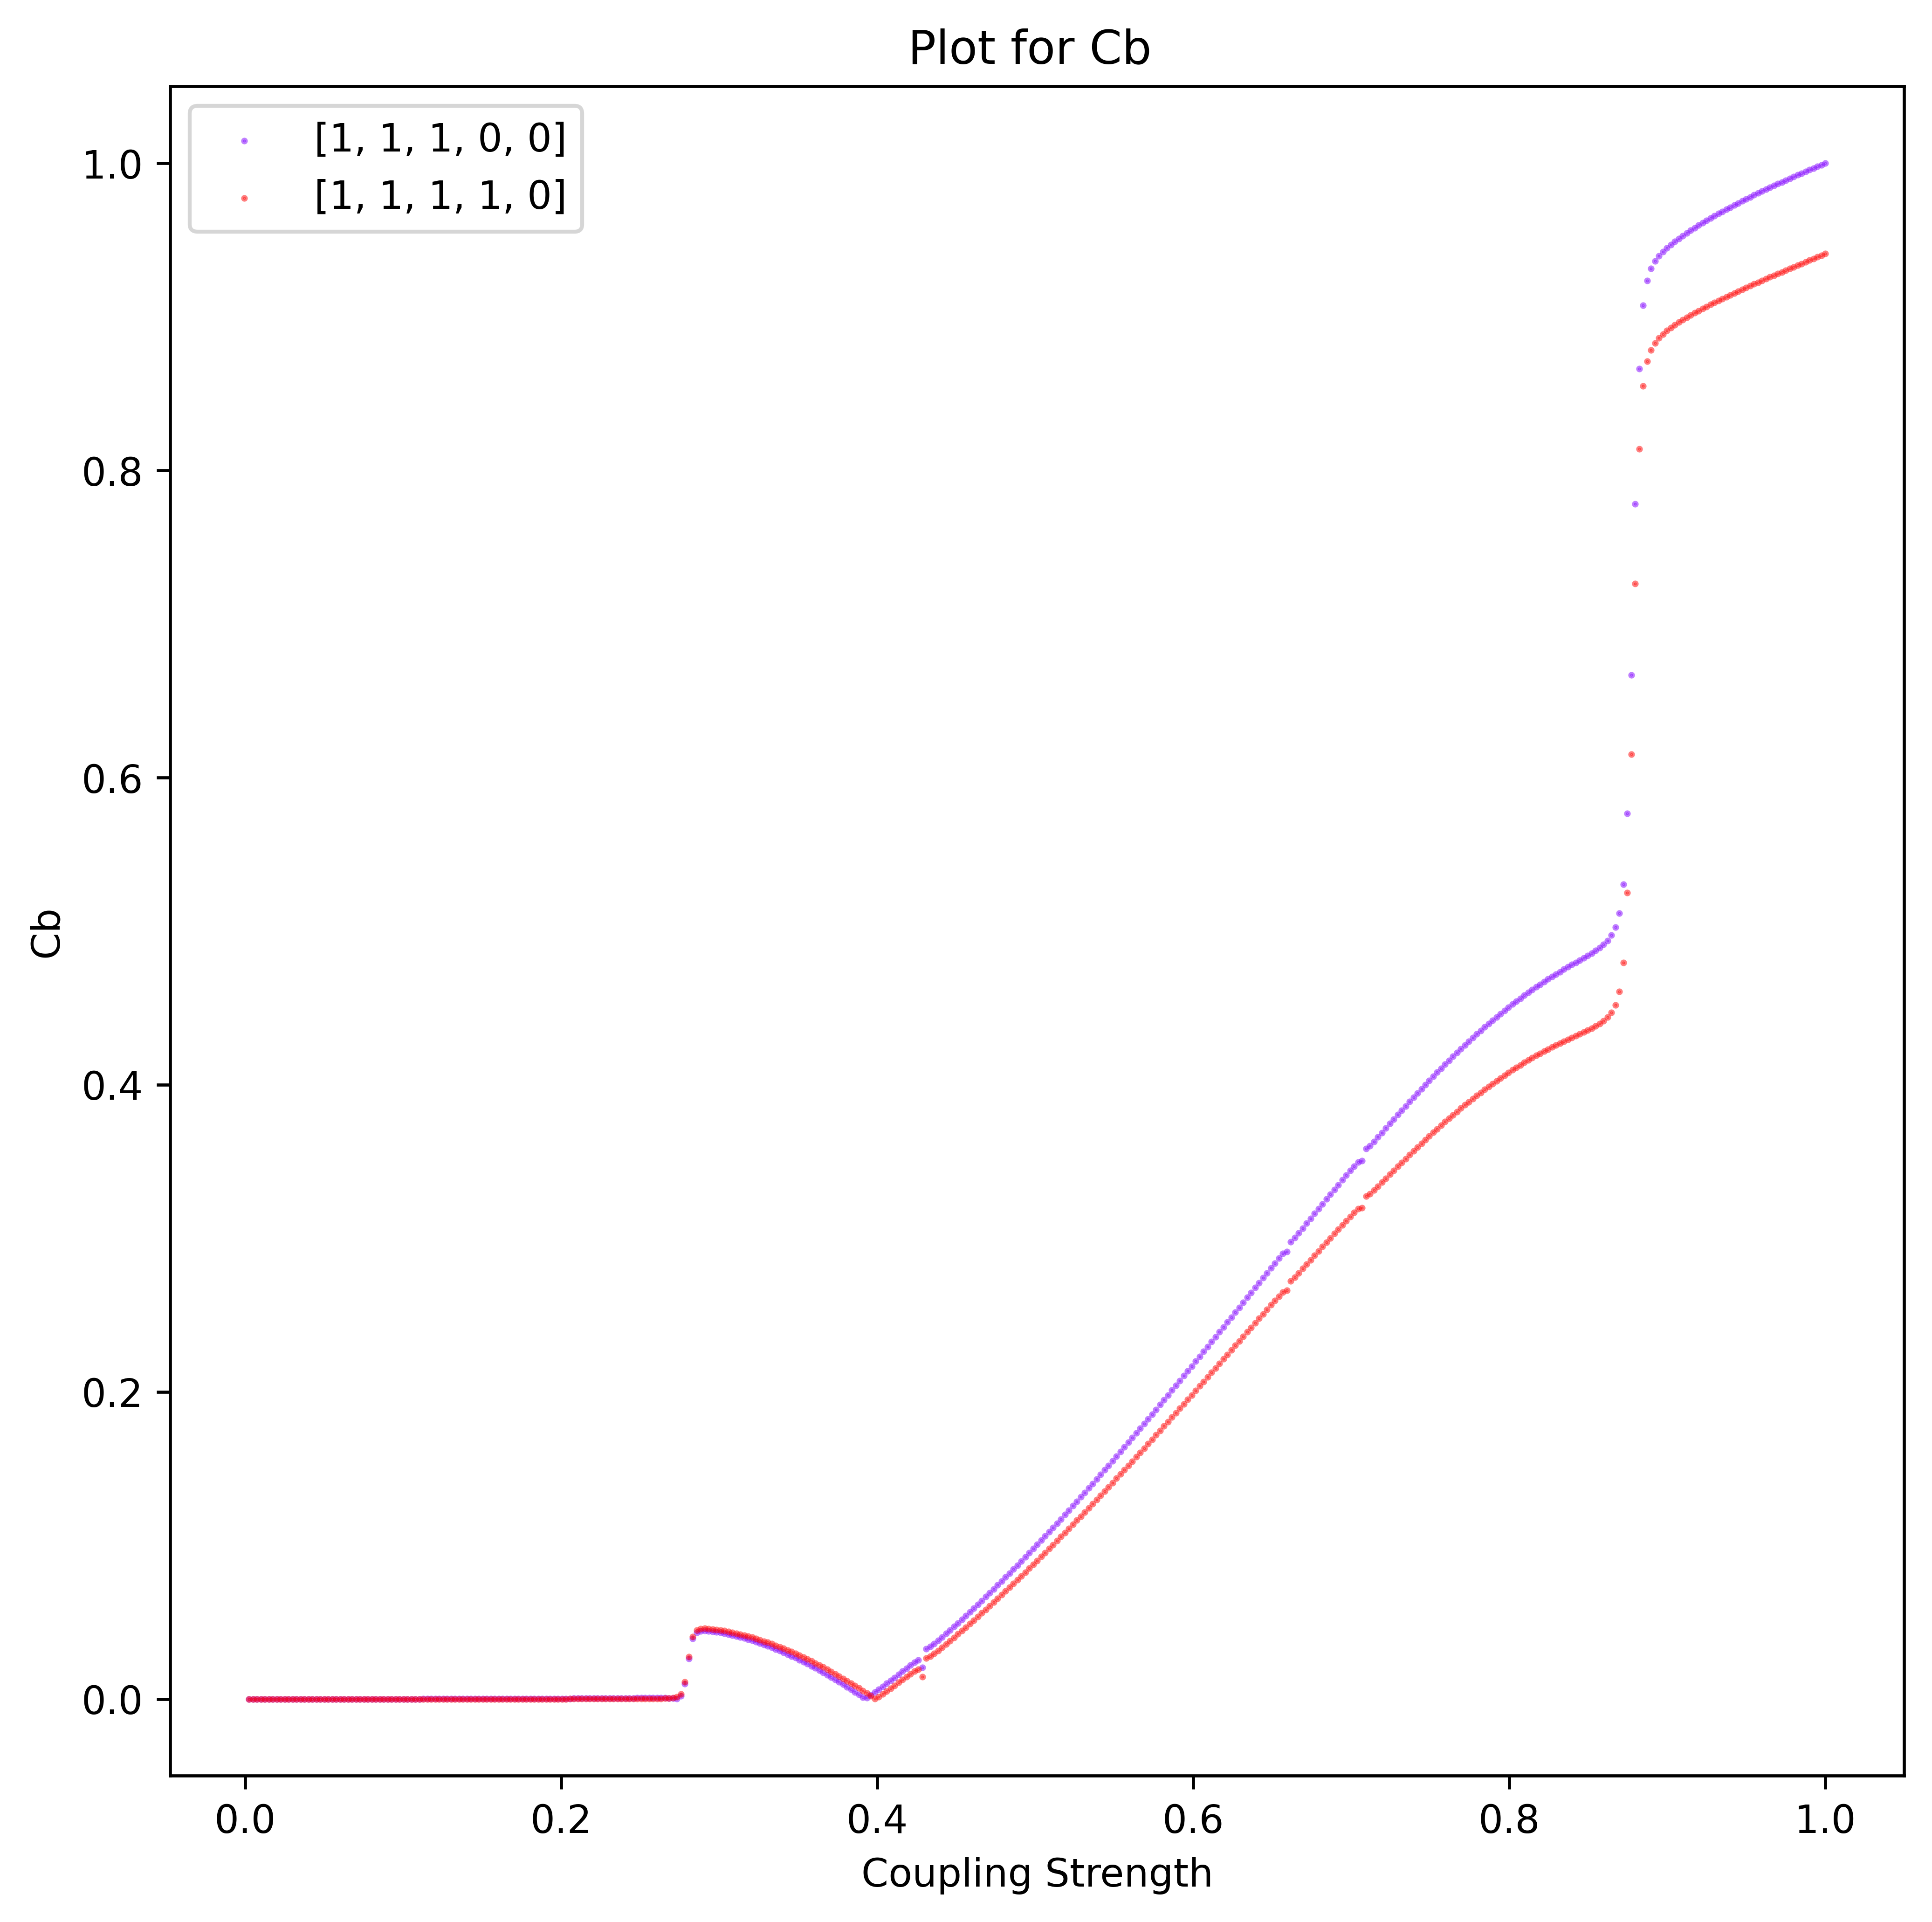

In [120]:
size = 8
fig = plt.figure(figsize=(size,size))
#plt.ylim(y_min, y_max)
for plot,b in zip(plt_arr_normal,bit_arr_normal):
    plt.scatter(plot.x,(plot.y/norm_denom),s = 0.5, label = str(b), color = plot.c, alpha=0.5)
    
plt.title(str("Plot for Cb "))
#assuming all have same x,y labels
plt.xlabel("Coupling Strength")
plt.ylabel("Cb")
plt.legend(loc='best')

Code for OTOC

$O_H(t) = e^{iH_s t} O_s e^{-iH_s t}$ , $ U = e^{iH_s t} $ 

In [ ]:
#for each T value
#also make this function take evol op as an argument
#also, this fn should not decide X,P. Take that as input
def cal_Aq(states_list,a,evol_op):
    A = []
    for i in range(len(a)):
        A_temp = 0
        x_op = (a[i] + a[i].dag())/2
        y_op = (a[i] - a[i].dag())/(2*1j)
        x_op_t = evol_op * x_op * evol_op.dag()
        op_com = commutator(x_op_t, y_op, 'normal')
        op_com_sq = op_com * op_com.dag()
        for state in states_list:
            A_temp += math.log(expect(op_com_sq,state))
        A.append(A_temp)
    return A

In [ ]:
def cal_otoc(run,timelist):
    tlist = run.tlist
    A_avg_arr = []
    
    for t in tqdm(range(len(tlist))):
        A_avg = []
        H = run.t_arch.H_const + run.t_arch.H_int(tlist[t])
        states_list = run.c_evec[t]
        for time_step in timelist:
            Q = (0+1j)*time_step*H
            evol_op = Q.expm()
            A = cal_Aq(states_list,run.t_arch.a,evol_op)
            A_avg.append(np.mean(A))            
        A_avg_arr.append(A_avg)
    
    return A_avg_arr

In [ ]:
tlist = [0.1]
tarch = transmon_arch(5,4)
run = run_data(tarch,tlist)
run.cal_all()

In [ ]:
len(run.c_evec[0])

In [ ]:
timelist = np.linspace(0.1,1,10)
otoc_arr = cal_otoc(run,timelist)

In [ ]:
otoc_arr

In [ ]:
for i in range(len(otoc_arr)):
    print(np.polyfit(timelist,otoc_arr[i],1))

In [ ]:
colors = cm.rainbow(np.linspace(0,1,len(tlist)))

In [ ]:
for y,c,t in zip(otoc_arr, colors,tlist):
    plt.figure(figsize=(8, 8))
    plt.scatter(timelist, y, color = c, s = 0.5)
    plt.plot(timelist,np.polyfit(timelist,y,1)[0]*timelist + np.polyfit(timelist,y,1)[1] )
    #plt.title(str(N) + " tranmons " + str(Nlevel)+ " level systems " + "OTOC")
    #plt.text(0.1,max(y)-1,"T val = "+ str(t) + " \n slope = " +str(np.polyfit(timelist,y,1)[0]))
    #plt.xlabel("time")
    #plt.ylabel("ln( |C(t)| )")


Code for Statistics Calculation

Spectral Distribution

In [ ]:
import statistics
import math
import numpy as np

In [ ]:
def spectral_distribution(eval):
    #eval = list of eigen values
    p = []
    for i in range(len(eval)-1):
        p.append(eval[i+1]-eval[i])
    r = []
    for i in range(len(p)-1):
        r.append(p[i]/p[i+1])
    R = []
    for ri in r:
        R.append(np.minimum(ri,1/ri))

    return r,R

In [ ]:
def return_dist(bucket_list,data ):
    #returns the distribution of data
    #bucket_list is used to count no of data points in each bucket i.e #data<b, >=b-1
    #this here is a very inefficient implimentation as it passes through all data
    #for each count
    count = []
    for i in range(len(bucket_list)-1):
        count_b = 0
        for d in data:
            if d>=bucket_list[i] and d < bucket_list[i+1]:
                count_b += 1

        count.append(count_b)
    
    return count


In [ ]:
#code to reuturn a poisson distribution in interval 0,1
def PMF_poisson(l,k):
    #l = \lambda
    return (l^k)*math.exp()

def return_poisson(bucket_list, count):
    #k = bucket list
    # \lambda = mean of data
    
    

In [ ]:
def KL(p,q):
    if len(p) != len(q):
        print("no of elements not equal")
        return
    sum = 0
    for i in range(len(p)):
        sum = sum + p[i]* math.log(p[i]/q[i])
    return sum

In [ ]:
#initial setting
N = 1 #no of transmons
Nlevel = 2 #bosonic operators to be simulated by "Nlevel" levels
tlist = np.linspace(0, 2, 20) # coupling strength vector

#Energy scale: Ej = 20Ghz, Ec = 250MHz, T = (5-20)MHz 
#ratio = 200/2.5/.1 
Ej = np.absolute(np.random.normal(200,50, N))
Ec = 2.5
id, a, na = operators(N, Nlevel)


In [ ]:
H = hamiltonian(id,a,na,Ec,Ej,0)
evals = H.eigenenergies()

In [ ]:
r,R = spectral_distribution(evals)

In [ ]:
bucket_list = np.linspace(0,1,50)
count = return_dist(bucket_list,R)

In [ ]:
count_total = np.sum(count)
count_percent = []
for c in count:
    count_percent.append(c*100/count_total)

In [ ]:
plt.scatter(bucket_list[:-1],count_percent,s = 0.5)

In [ ]:
bucket_list = np.linspace(0,1,50)
R_list = []
for t in tlist:
    #print(t)
    H = hamiltonian(id,a,na,Ec,Ej,t)
    evals = H.eigenenergies()
    #print(t,evals,"\n")
    r,R = spectral_distribution(evals)
    #R_list.append(R)
    #count = return_dist(bucket_list,R)
    fig, ax = plt.subplots(figsize =(5, 5))
    ax.hist(R, bins = bucket_list)
    #file_name = str(N) + "_tranmons_" + str(Nlevel)+ "_levels_"+ "_t value_" + str(tlist[t])
    plt.title(str(t))
    plt.xlabel("buckets")
    plt.ylabel("number of R")
   

In [ ]:
images_dir = '/content/drive/MyDrive/Chaos_Sim/Distributions'

for t in range(len(tlist)):
    fig, ax = plt.subplots(figsize =(5, 5))
    ax.hist(r_values[t], bins = r_arr[t][0])
    file_name = str(N) + "_tranmons_" + str(Nlevel)+ "_levels_"+ "_t value_" + str(tlist[t])
    plt.title(file_name)
    plt.xlabel("buckets")
    plt.ylabel("number of rn")
    plt.savefig(images_dir+"/"+ str(t)+".png")

In [ ]:
var_p = statistics.variance(p) 

IPR

In [ ]:
'''
def IPR(vecs,id):
    #vecs is a list of vectors
    IPR_val = 0
    for vec in vecs:
        exp_val = expect(id,vec)
        IPR_val = IPR_val + exp_val*exp_val
    return IPR_val/len(vecs)
'''

In [ ]:
t = 10
H = hamiltonian(id,a,na,Ec,Ej,t)

In [ ]:
band_no = 5

In [ ]:
band_val, band_vecs = band_states(H,na,band_no)
ipr_val = IPR(band_vecs,id)

In [ ]:
ipr_val

In [ ]:
#Gate Fidelity Runs


In [ ]:
'''
def cstates(H,na):
    #returns eigenvecs and eigenvalues of states that are computational
    #i.e have at max 1 excitation of transmons
    eigen_vals, eigen_vecs = H.eigenstates()
    c_val = []
    c_vec = []
    for i in range(len(eigen_vals)):
        c = 1
        vec = eigen_vecs[i]
        for nai in na:
            if expect(nai,vec) > 1.1:
                c = 0
                break
        if c==1 :
            c_val.append(eigen_vals[i])
            c_vec.append(eigen_vecs[i])

    return c_val,c_vec

def cstates_label(H,na):
    #returns evals, estates and occupation string of all cstates
    labels= []
    eigen_vals, eigen_vecs = H.eigenstates()
    c_val = []
    c_vec = []
    for i in range(len(eigen_vals)):
        if len(c_val) > 2**len(na):
            break
        c = 1
        blabel = []
        vec = eigen_vecs[i]
        for nai in na:
            temp = expect(nai,vec)
            if temp > 1.1:
                c = 0
                break
            blabel.append(temp)
        
        if c==1 :
            c_val.append(eigen_vals[i])
            c_vec.append(eigen_vecs[i])
            labels.append(blabel)

    return c_val,c_vec ,labels

def band_states(H,na,band_no):
    #returns all eigenvectors in given band no
    eigen_vals, eigen_vecs = H.eigenstates()
    b_val = []
    b_vec = []
    total_na = 0
    error_tol = 0.2

    for nai in na:
        total_na = total_na + nai    

    for i in range(len(eigen_vals)):
        vec = eigen_vecs[i]
        c = expect(total_na,vec)
        if c < (band_no + error_tol) and c > (band_no - error_tol)  :
            b_val.append(eigen_vals[i])
            b_vec.append(eigen_vecs[i])

    return b_val,b_vec
'''

'''
class transmon_arch:
    #init variables
    def __init__(self, N, Nlevel,error=0):
        #Energy scale: Ej = 20Ghz +- 10Ghz, Ec = 250MHz, T = (5-20)MHz 
        #ratio = 200/2.5/.1 
        self.N = N
        self.Nlevel = Nlevel
        self.Ej =  np.absolute(np.random.normal(200,50, N))
        self.Ec = np.absolute(np.random.normal(2.5,0.2, N))
        self.error = error #error width
        self.id = 0
        self.a = 0
        self.na = 0
        self.H_const = 0
        self.operators()
        self.H_c()
        
    def operators(self):
        Neye = []
        id = [] #tensored identiry operator
        a = [] #list of tensored destruction operators
        na = [] #list of number operators
        for i in  range(self.N):
            Neye.append(qeye(self.Nlevel))
        for i in range(self.N):
            temp = Neye.copy()
            temp[i] = destroy(self.Nlevel)
            a.append(tensor(temp))
        for i in range(self.N):
            na.append(a[i].dag()*a[i])
        id = tensor(Neye)

        self.id = id
        self.a = a
        self.na = na

    def H_c(self):
        #constant part of hamiltonian
        N = self.N
        #initialize v ,t
        v = np.zeros(N)
        for i in range(N):
            v[i] = math.sqrt(8*self.Ej[i]*self.Ec[i])
        
        H1 = 0
        H2 = 0
        for i in range(N):
            e = abs(np.random.normal(1, self.error))
            H1 = H1 + self.na[i]*v[i]*e
            H2 = H2 + self.Ec[i]*(self.na[i]*(self.na[i]+1))*e
            
        H2 = -0.5*H2        
        self.H_const = H1 + H2
    
    def H_int(self,T,RWA = False):
        N = self.N
        Ec = self.Ec
        Ej = self.Ej
        t = np.zeros((N,N))
        for i in range(N-1):
            t[i][i+1] = (T/(4*(2*((Ec[i]*Ec[i+1])**1/float(2)))**(1/float(2))))*((Ej[i]*Ej[i+1])**(1/float(4)))
        
        H3 = 0
        if RWA:
            for i in range(N):
                for j in range(N):
                    H3 = H3 + t[i][j]*(self.a[i]*self.a[j].dag()+self.a[i].dag()*self.a[j])
            
        if not RWA:
            for i in range(N):
                for j in range(N):
                    H3 = H3 + t[i][j]*(self.a[i] + self.a[i].dag())*(self.a[j].dag()+self.a[j])
        return H3
        
class run_data:
    def __init__(self, t_arch,tlist,RWA=False, update_error = False, global_error = 0):
        self.t_arch = t_arch
        self.tlist = tlist
        self.spectrum_arr = 0
        self.cspectrum_arr = 0
        self.evec = []
        self.c_evec = []
        self.RWA = RWA
        self.update_error = update_error
        self.global_error = global_error

    def spectrum_cal(self):
        spectrum_arr = []
        for t in tqdm(self.tlist):
            H3 = self.t_arch.H_int(t,RWA = self.RWA)
            if self.update_error:
                self.t_arch.H_c()
            H = abs(np.random.normal(1, self.global_error))*self.t_arch.H_const + H3
            evals = H.eigenenergies()
            spectrum_arr.append([t,evals])

        self.spectrum_arr = spectrum_arr

    def evec_cal(self):
        evec_arr = []
        for t in tqdm(self.tlist):
            H3 = self.t_arch.H_int(t,RWA = self.RWA)
            if self.update_error:
                self.t_arch.H_c()
            H = abs(np.random.normal(1, self.global_error))*self.t_arch.H_const + H3
            eigen_vals, eigen_vecs = H.eigenstates()
            spectrum_arr.append([t,eigen_vals])
            evec_arr.append(eigen_vecs)

        self.evec = evec_arr
        self.spectrum_arr = spectrum_arr

        
    def cspectrum_cal(self):
        cspectrum_arr = []
        c_evec_arr = []
        for t in tqdm(self.tlist):
            H3 = self.t_arch.H_int(t,RWA = self.RWA)
            if self.update_error:
                self.t_arch.H_c()
            H = abs(np.random.normal(1, self.global_error))*self.t_arch.H_const + H3
            evals,evecs, labels = cstates_label(H, self.t_arch.na)
            cspectrum_arr.append([t, evals, labels])
            c_evec_arr.append(evecs)
        
        self.cspectrum_arr = cspectrum_arr
        self.c_evec = c_evec_arr

class plot_spectrum:    
    def __init__(self, N ,Nlevel,spectrum_arr):
            self.title = str(str(N) + " tranmons " + str(Nlevel)+ " level systems")
            self.x_label = str("T value")
            self.y_label = str("eigenvalues")
            self.size = 10
            self.c = 'b'
            self.x = 0
            self.y = 0
            self.label = 0
            self.spectrum_arr = spectrum_arr
            self.spectrum_data()

    def spectrum_data(self):
        x = []
        y = []
        label = []
        fig = 0
        if len(self.spectrum_arr[0]) == 2:
            for i in self.spectrum_arr:
                for e in i[1]:
                    x.append(i[0])
                    y.append(e)
            self.x = x
            self.y = y
        elif len(self.spectrum_arr[0]) == 3:
            for i in self.spectrum_arr:
                for e,l in zip(i[1],i[2]):
                    x.append(i[0])
                    y.append(e)
                    label.append(l)
            self.x = x
            self.y = y
            self.label = label
    def label_t(self,t=0):
        label_t_arr = []
        label_t_y = []
        for x_temp,y_temp,l in zip(self.x,self.y,self.label):
            if x_temp == t:
                label_t_arr.append(l)
                label_t_y.append(y_temp)
        return label_t_arr , label_t_y

    def view_fig(self, y_min = -1, y_max = -1, use_label=False, title = -1):
        self.fig = plt.figure(figsize=(self.size,self.size))
        if not((y_min ==-1 or y_max ==-1) or (y_min > y_max) ):
            plt.ylim(y_min, y_max)
        plt.scatter(self.x,self.y,s = 0.5, color = self.c)
        if use_label:
            label_t_arr , label_t_y = self.label_t()
            for l,y in zip(label_t_arr , label_t_y):
                plt.text(0.0,y,str(l))
        if title == -1:
            title = self.title
        plt.title(title)
        plt.xlabel(self.x_label)
        plt.ylabel(self.y_label)
        
def mult_plot(*plots, size = 10, y_min = -1, y_max = -1, use_label = False, title = "overlapped",x_label = "T value", y_label = "eigenvalues"):
    fig = plt.figure(figsize=(size,size))
    if not((y_min ==-1 or y_max ==-1) or (y_min > y_max) ):
        plt.ylim(y_min, y_max)
    
    for p in plots:
        plt.scatter(p.x,p.y,s = 0.5, color = p.c, alpha=0.5)
        if use_label:
            label_t_arr , label_t_y = p.label_t()
            for l,y in zip(label_t_arr , label_t_y):
                plt.text(0.0,y,str(l))
    plt.title(str(title))
    #assuming all have same x,y labels
    plt.xlabel(x_label)
    plt.ylabel(y_label)
'''